In [1]:
%matplotlib ipympl
from methods import topology_AAGE, NN_topoptimizer, Journal



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Default input parameters
nelx=200        # element number per x axis             # !!!! NN optimizer work only with nelx, nely = 40
nely=80         # element number per y axis             # !!!! But we can make experiments without nn_iteration
                                                        # !!!! by defened simp_strart = end. This is an example.
volfrac=0.4     # volume fraction
rmin=5.4        # min radius
penal=3.0       # penalty coefficient
ft=1            # ft==0 -> sensitvity mode, ft==1 -> density mode

# create optimazers
opt_SIMP = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
opt_SIMP.lu_solver = True # to activate LU sparse solver
opt_NN = NN_topoptimizer('./trained_models/uniform/VOL_COEFF=100.0')    #  there is a bug: you can create NN_optimazer only once, next time you should restart kernel

# start expriments
experiment_1 = Journal(opt_SIMP, opt_NN, simp_start = 100, simp_inc = 6, nn_inc = 6, end = 100) # first 100 iterations will be performed using the SIMP method, 
                                                                                                # then 6 iterations will be performed sequentily using the NN_topoptimizer method,
                                                                                                # and 4 iterations using the SIMP method 
                                                                                                # until the total number of iterations is greater than 100.
experiment_1.start()    # start experiment
first_experiment_history = [experiment_1.loop_hsitory, experiment_1.obj_hist]   # get the history for cobvergence plot
anim = experiment_1.drow_process('180x50_(100).gif', 50, 10) # drow 50 first iteration with 10 fps. !! This line will save th giff to local directory without opening it

Minimum compliance problem with OC
ndes: 200 x 80
volfrac: 0.4, rmin: 5.4, penal: 3.0
Filter method: Density based



INFO:tensorflow:Restoring parameters from ./trained_models/uniform/VOL_COEFF=100.0


d:\Python_projects\NLA_PROJECT\NLA_Topology_team\topo_fem\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


Iteration N:  1 	 optimizer: TopoSIMP 	 Objective function value:  11396.48  Time execution:  1.487
Iteration N:  2 	 optimizer: TopoSIMP 	 Objective function value:  6530.89  Time execution:  1.465
Iteration N:  3 	 optimizer: TopoSIMP 	 Objective function value:  4546.56  Time execution:  1.487
Iteration N:  4 	 optimizer: TopoSIMP 	 Objective function value:  3609.4  Time execution:  1.54
Iteration N:  5 	 optimizer: TopoSIMP 	 Objective function value:  3258.72  Time execution:  1.527
Iteration N:  6 	 optimizer: TopoSIMP 	 Objective function value:  3051.43  Time execution:  1.531
Iteration N:  7 	 optimizer: TopoSIMP 	 Objective function value:  2924.04  Time execution:  1.537
Iteration N:  8 	 optimizer: TopoSIMP 	 Objective function value:  2802.3  Time execution:  1.537
Iteration N:  9 	 optimizer: TopoSIMP 	 Objective function value:  2693.94  Time execution:  1.578
Iteration N:  10 	 optimizer: TopoSIMP 	 Objective function value:  2565.25  Time execution:  1.504
Iteration N

MovieWriter imagemagick unavailable; using Pillow instead.
d:\Python_projects\NLA_PROJECT\NLA_Topology_team\topo_fem\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


Rendering it:  0
Rendering it:  0
Rendering it:  1
Rendering it:  2
Rendering it:  3
Rendering it:  4
Rendering it:  5
Rendering it:  6
Rendering it:  7
Rendering it:  8
Rendering it:  9
Rendering it:  10
Rendering it:  11
Rendering it:  12
Rendering it:  13
Rendering it:  14
Rendering it:  15
Rendering it:  16
Rendering it:  17
Rendering it:  18
Rendering it:  19
Rendering it:  20
Rendering it:  21
Rendering it:  22
Rendering it:  23
Rendering it:  24
Rendering it:  25
Rendering it:  26
Rendering it:  27
Rendering it:  28
Rendering it:  29
Rendering it:  30
Rendering it:  31
Rendering it:  32
Rendering it:  33
Rendering it:  34
Rendering it:  35
Rendering it:  36
Rendering it:  37
Rendering it:  38
Rendering it:  39
Rendering it:  40
Rendering it:  41
Rendering it:  42
Rendering it:  43
Rendering it:  44
Rendering it:  45
Rendering it:  46
Rendering it:  47
Rendering it:  48
Rendering it:  49


This an example of rendered giffs.

<img src="180x50_(100).gif">

In [3]:
# build a few diffrent experiments with NN
# Default input parameters
nelx=40        
nely=40         
volfrac=0.4
rmin=5.4
penal=3.0
ft=1 # ft==0 -> sens, ft==1 -> dens


opt_SIMP = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
experiment_2 = Journal(opt_SIMP, opt_NN, simp_start = 5, simp_inc = 6, nn_inc = 6, end = 100)
experiment_2.start()
experiment_2_history = [experiment_2.loop_hsitory, experiment_2.obj_hist]
anim = experiment_2.drow_process('40x40_(5-(6)-(6)).gif', 100, 20)

opt_SIMP = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
experiment_3 = Journal(opt_SIMP, opt_NN, simp_start = 5, simp_inc = 6, nn_inc = 95, end = 100)
experiment_3.start()
experiment_3_history = [experiment_3.loop_hsitory, experiment_3.obj_hist]
anim = experiment_3.drow_process('40x40_(5-(6)-(95)).gif', 100, 20)

opt_SIMP = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
experiment_4 = Journal(opt_SIMP, opt_NN, simp_start = 5, simp_inc = 6, nn_inc = 75, end = 100)
experiment_4.start()
experiment_4_history = [experiment_4.loop_hsitory, experiment_4.obj_hist]
anim = experiment_4.drow_process('40x40_(5-(6)-(75)).gif', 100, 20)

opt_SIMP = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
experiment_5 = Journal(opt_SIMP, opt_NN, simp_start = 10, simp_inc = 10, nn_inc = 70, end = 100)
experiment_5.start()
experiment_5_history = [experiment_5.loop_hsitory, experiment_5.obj_hist]
anim = experiment_5.drow_process('40x40_(10-(10)-(70)).gif', 100, 20)

opt_SIMP = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
experiment_6 = Journal(opt_SIMP, opt_NN, simp_start = 15, simp_inc = 15, nn_inc = 70, end = 100)
experiment_6.start()
experiment_6_history = [experiment_6.loop_hsitory, experiment_6.obj_hist]
anim = experiment_6.drow_process('40x40_(15-(15)-(70)).gif', 100, 20)   


Minimum compliance problem with OC
ndes: 40 x 40
volfrac: 0.4, rmin: 5.4, penal: 3.0
Filter method: Density based
Iteration N:  1 	 optimizer: TopoSIMP 	 Objective function value:  2131.19  Time execution:  0.018
Iteration N:  2 	 optimizer: TopoSIMP 	 Objective function value:  1086.59  Time execution:  0.018
Iteration N:  3 	 optimizer: TopoSIMP 	 Objective function value:  741.52  Time execution:  0.018
Iteration N:  4 	 optimizer: TopoSIMP 	 Objective function value:  576.04  Time execution:  0.018
Iteration N:  5 	 optimizer: TopoSIMP 	 Objective function value:  499.34  Time execution:  0.018
Iteration N:  6 	 optimizer: TopoNN 	 Objective function value:  251.17  Time execution:  0.086
Iteration N:  7 	 optimizer: TopoNN 	 Objective function value:  217.45  Time execution:  0.061
Iteration N:  8 	 optimizer: TopoNN 	 Objective function value:  213.16  Time execution:  0.058
Iteration N:  9 	 optimizer: TopoNN 	 Objective function value:  205.18  Time execution:  0.063
Iteration 

MovieWriter imagemagick unavailable; using Pillow instead.


Rendering it:  0
Rendering it:  0
Rendering it:  1
Rendering it:  2
Rendering it:  3
Rendering it:  4
Rendering it:  5
Rendering it:  6
Rendering it:  7
Rendering it:  8
Rendering it:  9
Rendering it:  10
Rendering it:  11
Rendering it:  12
Rendering it:  13
Rendering it:  14
Rendering it:  15
Rendering it:  16
Rendering it:  17
Rendering it:  18
Rendering it:  19
Rendering it:  20
Rendering it:  21
Rendering it:  22
Rendering it:  23
Rendering it:  24
Rendering it:  25
Rendering it:  26
Rendering it:  27
Rendering it:  28
Rendering it:  29
Rendering it:  30
Rendering it:  31
Rendering it:  32
Rendering it:  33
Rendering it:  34
Rendering it:  35
Rendering it:  36
Rendering it:  37
Rendering it:  38
Rendering it:  39
Rendering it:  40
Rendering it:  41
Rendering it:  42
Rendering it:  43
Rendering it:  44
Rendering it:  45
Rendering it:  46
Rendering it:  47
Rendering it:  48
Rendering it:  49
Rendering it:  50
Rendering it:  51
Rendering it:  52
Rendering it:  53
Rendering it:  54
Ren

MovieWriter imagemagick unavailable; using Pillow instead.


Rendering it:  0
Rendering it:  0
Rendering it:  1
Rendering it:  2
Rendering it:  3
Rendering it:  4
Rendering it:  5
Rendering it:  6
Rendering it:  7
Rendering it:  8
Rendering it:  9
Rendering it:  10
Rendering it:  11
Rendering it:  12
Rendering it:  13
Rendering it:  14
Rendering it:  15
Rendering it:  16
Rendering it:  17
Rendering it:  18
Rendering it:  19
Rendering it:  20
Rendering it:  21
Rendering it:  22
Rendering it:  23
Rendering it:  24
Rendering it:  25
Rendering it:  26
Rendering it:  27
Rendering it:  28
Rendering it:  29
Rendering it:  30
Rendering it:  31
Rendering it:  32
Rendering it:  33
Rendering it:  34
Rendering it:  35
Rendering it:  36
Rendering it:  37
Rendering it:  38
Rendering it:  39
Rendering it:  40
Rendering it:  41
Rendering it:  42
Rendering it:  43
Rendering it:  44
Rendering it:  45
Rendering it:  46
Rendering it:  47
Rendering it:  48
Rendering it:  49
Rendering it:  50
Rendering it:  51
Rendering it:  52
Rendering it:  53
Rendering it:  54
Ren

MovieWriter imagemagick unavailable; using Pillow instead.


Rendering it:  0
Rendering it:  0
Rendering it:  1
Rendering it:  2
Rendering it:  3
Rendering it:  4
Rendering it:  5
Rendering it:  6
Rendering it:  7
Rendering it:  8
Rendering it:  9
Rendering it:  10
Rendering it:  11
Rendering it:  12
Rendering it:  13
Rendering it:  14
Rendering it:  15
Rendering it:  16
Rendering it:  17
Rendering it:  18
Rendering it:  19
Rendering it:  20
Rendering it:  21
Rendering it:  22
Rendering it:  23
Rendering it:  24
Rendering it:  25
Rendering it:  26
Rendering it:  27
Rendering it:  28
Rendering it:  29
Rendering it:  30
Rendering it:  31
Rendering it:  32
Rendering it:  33
Rendering it:  34
Rendering it:  35
Rendering it:  36
Rendering it:  37
Rendering it:  38
Rendering it:  39
Rendering it:  40
Rendering it:  41
Rendering it:  42
Rendering it:  43
Rendering it:  44
Rendering it:  45
Rendering it:  46
Rendering it:  47
Rendering it:  48
Rendering it:  49
Rendering it:  50
Rendering it:  51
Rendering it:  52
Rendering it:  53
Rendering it:  54
Ren

MovieWriter imagemagick unavailable; using Pillow instead.


Rendering it:  0
Rendering it:  0
Rendering it:  1
Rendering it:  2
Rendering it:  3
Rendering it:  4
Rendering it:  5
Rendering it:  6
Rendering it:  7
Rendering it:  8
Rendering it:  9
Rendering it:  10
Rendering it:  11
Rendering it:  12
Rendering it:  13
Rendering it:  14
Rendering it:  15
Rendering it:  16
Rendering it:  17
Rendering it:  18
Rendering it:  19
Rendering it:  20
Rendering it:  21
Rendering it:  22
Rendering it:  23
Rendering it:  24
Rendering it:  25
Rendering it:  26
Rendering it:  27
Rendering it:  28
Rendering it:  29
Rendering it:  30
Rendering it:  31
Rendering it:  32
Rendering it:  33
Rendering it:  34
Rendering it:  35
Rendering it:  36
Rendering it:  37
Rendering it:  38
Rendering it:  39
Rendering it:  40
Rendering it:  41
Rendering it:  42
Rendering it:  43
Rendering it:  44
Rendering it:  45
Rendering it:  46
Rendering it:  47
Rendering it:  48
Rendering it:  49
Rendering it:  50
Rendering it:  51
Rendering it:  52
Rendering it:  53
Rendering it:  54
Ren

MovieWriter imagemagick unavailable; using Pillow instead.


Rendering it:  0
Rendering it:  0
Rendering it:  1
Rendering it:  2
Rendering it:  3
Rendering it:  4
Rendering it:  5
Rendering it:  6
Rendering it:  7
Rendering it:  8
Rendering it:  9
Rendering it:  10
Rendering it:  11
Rendering it:  12
Rendering it:  13
Rendering it:  14
Rendering it:  15
Rendering it:  16
Rendering it:  17
Rendering it:  18
Rendering it:  19
Rendering it:  20
Rendering it:  21
Rendering it:  22
Rendering it:  23
Rendering it:  24
Rendering it:  25
Rendering it:  26
Rendering it:  27
Rendering it:  28
Rendering it:  29
Rendering it:  30
Rendering it:  31
Rendering it:  32
Rendering it:  33
Rendering it:  34
Rendering it:  35
Rendering it:  36
Rendering it:  37
Rendering it:  38
Rendering it:  39
Rendering it:  40
Rendering it:  41
Rendering it:  42
Rendering it:  43
Rendering it:  44
Rendering it:  45
Rendering it:  46
Rendering it:  47
Rendering it:  48
Rendering it:  49
Rendering it:  50
Rendering it:  51
Rendering it:  52
Rendering it:  53
Rendering it:  54
Ren

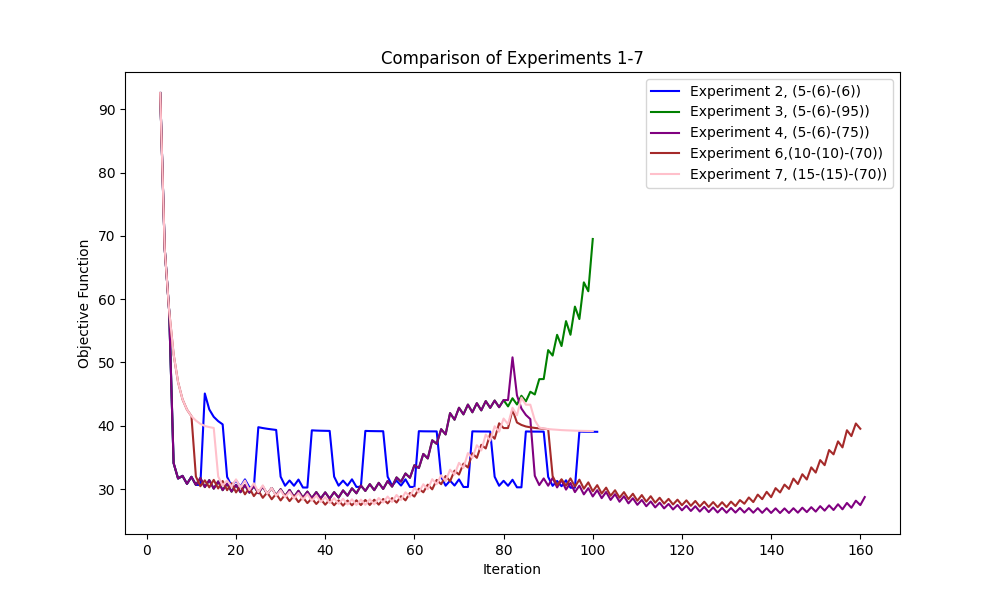

In [9]:
import matplotlib.pyplot as plt

start_index = 2

plt.figure(figsize=(10, 6))

plt.plot(experiment_2_history[0][start_index:], experiment_2_history[1][start_index:], label='Experiment 2, (5-(6)-(6))', color='blue')
plt.plot(experiment_3_history[0][start_index:], experiment_3_history[1][start_index:], label='Experiment 3, (5-(6)-(95))', color='green')
plt.plot(experiment_4_history[0][start_index:], experiment_4_history[1][start_index:], label='Experiment 4, (5-(6)-(75))', color='purple')
plt.plot(experiment_5_history[0][start_index:], experiment_5_history[1][start_index:], label='Experiment 6,(10-(10)-(70))', color='brown')
plt.plot(experiment_6_history[0][start_index:], experiment_6_history[1][start_index:], label='Experiment 7, (15-(15)-(70))', color='pink')

plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.title('Comparison of Experiments 1-7')

plt.legend()

plt.show()


Let's see the first experiment result

<img src="40x40_(5-(6)-(6)).gif">
